# CNN trained with unknown class
****
This is a cleaned up version of the model in Preliminary_CNN. It looks at the data as a csv file from an MFCC (which can be configured to draw in other data types) and builds a CNN with 2 convolutional layers, followed by a dropout layer, two fully connected layers, followed by another dropout layer and finally the output layer.

As before the tensorflow tutorial by Magnus Pedersen on https://github.com/Hvass-Labs/TensorFlow-Tutorials is the guide for many of the functions used

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import matplotlib.image as img
import numpy as np
import IPython.display as ipd
import librosa.display
import time
import math
import re
import os

from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from datetime import timedelta
from PIL import Image
from scipy import signal
from scipy.io import wavfile

In [2]:
tf.__version__

'1.10.0'

## Setting up useful constants
****
The CNN as well as data importing users several constant numbers, which we will define here.

In [3]:
# Convolutional Layer 1.
filter_size1 = 7         # number of pixels in one side of the filter
num_filters1 = 56         # number of filters

# Convolutional Layer 2.
filter_size2 = 7
num_filters2 = 112

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.
fc_size_2 = 256

# The number of pixels in each dimension of an image.
img_height = 128 # 161 for spec, 128 for mfcc
img_width = 32 #99 for spec 32 for mfcc

# The images are stored in one-dimensional arrays of this length.
img_size_flat = img_height * img_width

# Tuple with height and width of images used to reshape arrays.
img_shape = (128, 32)# (161,99)

# Number of classes, one class for each of 10 digits.
num_classes = 12

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

#The file path for the original audio files
audio_path = 'train/audio/'

POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

## Loading the Data
****
The strategy here will be to not load the data all at once, but instead create a dataframe containing labels (strings, integers and one_hots) as well as the the filepath. This way when training we can load only the data being used at that moment, freeing up memory. This function also combines all the datafiles which are *not* in the `POSSIBLE_LABELS` into one large unknown class. This will need to be down-sampled for training.

In [4]:
def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_") # for file types add '.+(type)'
    all_files = glob(os.path.join(data_dir, 'mfcc/train/*/*')) # for file types at (type)
                                                            # file path csv for 1sec exactly, and csv_full
                                                            # for all file
                                                            # mfcc/ for mfcc files

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_clips = fin.readlines()
        validation_files = [x[:-3] for x in validation_clips] # for file types at "+'(type)'" to [:-3]
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]
            label_vec = np.eye(len(id2name))[label_id]
            sound_path = audio_path + "/".join(entry.strip("/").split('/')[2:]) + '.wav'#str(entry)

            sample = (label, label_id, label_vec, uid, entry, sound_path)
            if uid in valset:
                #if # only include val set that is precisely 1 sec
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    
    columns_list = ['label', 'label_id', 'label_vec', 'user_id', 'file_name', 'audio_file']
    
    train_df = pd.DataFrame(train, columns = columns_list)
    valid_df = pd.DataFrame(val, columns = columns_list)
    
    return train_df, valid_df

In [5]:
train_df, valid_df = load_data('')
train_df.head()

There are 57923 train and 6798 val samples


,label,label_id,label_vec,user_id,file_name,audio_file
0,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",3bfd30e6,mfcc/train/right/3bfd30e6_nohash_2,train/audio/right/3bfd30e6_nohash_2.wav
1,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",dabf67d9,mfcc/train/right/dabf67d9_nohash_0,train/audio/right/dabf67d9_nohash_0.wav
2,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",b7a0754f,mfcc/train/right/b7a0754f_nohash_0,train/audio/right/b7a0754f_nohash_0.wav
3,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",a1cff772,mfcc/train/right/a1cff772_nohash_2,train/audio/right/a1cff772_nohash_2.wav
4,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",28e47b1a,mfcc/train/right/28e47b1a_nohash_1,train/audio/right/28e47b1a_nohash_1.wav


#### Label names

We will also create a small pandas series which records the label names to label id, to refer to later.

In [6]:
label_df = train_df[['label','label_id']].drop_duplicates(
    subset=None, keep='first', inplace=False).set_index('label_id')
label_names = label_df['label'].sort_index()
label_names

label_id
0         yes
1          no
2          up
3        down
4        left
5       right
6          on
7         off
8        stop
9          go
11    unknown
Name: label, dtype: object

### Downsampling
Below we will note from the value counts that the unknown class has a lot more observations. We will use a simple downsampler to correct this by downsampling the unknown class to the size as the average of the others.

In [7]:
train_df['label_id'].value_counts()

11    36818
8      2134
0      2116
2      2115
9      2112
5      2111
6      2110
4      2106
1      2105
7      2101
3      2095
Name: label_id, dtype: int64

In [8]:
avg_size = np.int(train_df[train_df['label_id'] != 11]['label_id'].value_counts().mean())
print(avg_size)
df_maj = train_df[train_df['label_id'] == 11]
df_rest = train_df[train_df['label_id'] != 11]

df_majority_downsampled = resample(df_maj, 
                                   replace=False,    # sample without replacement
                                   n_samples=avg_size,     # to match minority class
                                   random_state=5)

train_DS = pd.concat([df_majority_downsampled, df_rest]) # This will be the dataframe we use in the program
train_DS.head()

2110


,label,label_id,label_vec,user_id,file_name,audio_file
38923,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1625acd8,mfcc/train/marvin/1625acd8_nohash_1,train/audio/marvin/1625acd8_nohash_1.wav
53094,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9aa5439d,mfcc/train/five/9aa5439d_nohash_2,train/audio/five/9aa5439d_nohash_2.wav
19083,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",60472d26,mfcc/train/nine/60472d26_nohash_1,train/audio/nine/60472d26_nohash_1.wav
10120,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44dad20e,mfcc/train/happy/44dad20e_nohash_1,train/audio/happy/44dad20e_nohash_1.wav
57029,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",937b433e,mfcc/train/four/937b433e_nohash_0,train/audio/four/937b433e_nohash_0.wav


In [9]:
train_DS['label_id'].value_counts()

8     2134
0     2116
2     2115
9     2112
5     2111
11    2110
6     2110
4     2106
1     2105
7     2101
3     2095
Name: label_id, dtype: int64

In [10]:
def play_sound(files, cls_true, cls_pred=None):
    assert len(files) == len(cls_true) == 9
    
    for i in range(len(cls_true)):
        
        sample_rate, samples = wavfile.read(files[i])

        if cls_pred is None:
            print("True: {0}".format(label_names[cls_true[i]]))
        else:
            print("True: {0}, Pred: {1}".format(label_names[cls_true[i]], label_names[cls_pred[i]]))
            
        ipd.display(ipd.Audio(samples, rate=sample_rate))

In [11]:
ran_files = train_DS.sample(9)#[train_df['label'] != 'unknown'].sample(9)

files = [x for x in ran_files['audio_file']]

# Get the true classes for those images.
cls_true = [y for y in ran_files['label_id']]
true_names = [y for y in ran_files['label']]

play_sound(files=files, cls_true=cls_true)
#files

True: unknown


True: stop


True: on


True: stop


True: up


True: go


True: on


True: right


True: off


### Helper-functions for creating new variables
****
Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [12]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## Creating CNN layers
****
### Convolutional layers

We begin by defining a function which creates a convolutional layer. It is assumed that the input is a 4-dim tensor with the following dimensions:

1. Image number.
2. Y-axis of each image.
3. X-axis of each image.
4. Channels of each image.

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer. Though it is easiest if we stick with single channels.

The output is another 4-dim tensor with the following dimensions:

1. Image number, same as input.
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [13]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # The padding is removed as we padded our data ahead of time.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME'
                        )

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME'
                              )

    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [14]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]
    return layer_flat, num_features

In [15]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables.
****
We need to define a number of placeholder variables to allow the model to put itself together without data.

First we define the placeholder variable for the input images. The data-type is `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [16]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_height, img_width, num_channels])

Next we have the placeholder variable for the true labels associated with the audio files that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [17]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

We will also need placeholders for the dropout layers.

In [18]:
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)

### Convolutional Layers

The first convolutional layer takes `x_image` as input and creates `num_filters1` different filters, each having width and height equal to `filter_size1`. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

Next, create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [19]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 64, 16, 56) dtype=float32>

In [20]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=num_filters1,
                                            filter_size=filter_size2,
                                            num_filters=num_filters2,
                                            use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 32, 8, 112) dtype=float32>

### Middle Layers

Next we will add some middle layers. The first will flatten the matrices from the output of the convolutional layers and the next will be a dropout layer which will reduce the number of features in training to prevent overfitting.

In [21]:
layer_flat, num_features = flatten_layer(layer_conv2)
print(layer_flat, num_features)

dropout_1 = tf.nn.dropout(layer_flat, keep_prob_1)
print(dropout_1)

Tensor("Reshape_1:0", shape=(?, 28672), dtype=float32) 28672
Tensor("dropout/mul:0", shape=(?, 28672), dtype=float32)


### Fully-Connected Layers

Now we will add some fully connected layers. The input is the flattened layer from the middle section. The number of neurons or nodes in the fully-connected layers are `fc_size` and `fc_size_2`. ReLU is used so we can learn non-linear relations.

After another dropout layer, we finish with another fully connected layer that outputs vectors of length 12 for determining which of the 12 classes the input image belongs to. Note that ReLU is not used in this layer.

In [22]:
layer_fc1 = new_fc_layer(input=dropout_1,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
print(layer_fc1)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size_2,
                         use_relu=True)
print(layer_fc2)

dropout_2 = tf.nn.dropout(layer_fc2, keep_prob_2)
print(dropout_2)

layer_fc3 = new_fc_layer(input=dropout_2,
                         num_inputs=fc_size_2,
                         num_outputs=num_classes,
                         use_relu=False)
print(layer_fc3)

Tensor("Relu_2:0", shape=(?, 256), dtype=float32)
Tensor("Relu_3:0", shape=(?, 256), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 256), dtype=float32)
Tensor("add_4:0", shape=(?, 12), dtype=float32)


### Predicted Class
****
The final fully-connected layer estimates how likely it is that the input image belongs to each of the 12 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

In [23]:
y_pred = tf.nn.softmax(layer_fc3) # This is where I should change for unknowns.
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function to be optimized

In [24]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## TensorFlow Run
****
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.
****
The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [53]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [54]:
RUN_NAME = 'Run 1 with 2 conv layers'

training_writer = tf.summary.FileWriter("./logs/{}/training".format(RUN_NAME), session.graph)
testing_writer = tf.summary.FileWriter("./logs/{}/testing".format(RUN_NAME), session.graph)

### Training and Testing Functions

Rather than run something at once, we will use a series of functions that does everything. This is from the tutorial linked above. The main benefit is that I can call data for training or testing in small batches at a time using the dataframes containing filenames. This limits the amout of data in memory at once, making this easier to run on home computers.

In [55]:
train_batch_size = 50
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        batch_df = train_DS.sample(train_batch_size)
        x_batch = np.array(
            [pd.read_csv(x, sep=',',header=None).T.values.tolist()[0] for x in batch_df['file_name']])
        y_true_batch = np.array([y for y in batch_df['label_vec']])
        #x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_prob_1: 0.5, keep_prob_2: 0.5}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [56]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    
    files = np.array([x for x in valid_df['audio_file']])[incorrect]
    
    cls_pred = cls_pred[incorrect]
    cls_true = np.array([y for y in valid_df['label_id']])[incorrect]

    play_sound(files=files[0:9],
               cls_true=cls_true[0:9], 
               cls_pred=cls_pred[0:9])

In [57]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = [y for y in valid_df['label_id']]
    #cls_true = data.y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [58]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    
    
    # Number of images in the test-set.
    num_test = len(valid_df)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0
    x_test_array = np.array([pd.read_csv(x, sep=',', 
                                         header=None).T.values.tolist()[0] for x in valid_df['file_name']])
    y_test_array = np.array([y for y in valid_df['label_vec']])
    while i < num_test:
        start_time = time.time()
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = x_test_array[i:j, :]
        #data.x_test[i:j, :]
        
        # Get the associated labels.
        labels = y_test_array[i:j, :]
        #labels = data.y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images, y_true: labels, keep_prob_1: 1, keep_prob_2: 1}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        # Ending time.
        end_time = time.time()

        # Difference between start and end-times.
        time_dif = end_time - start_time

        #print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
        #print("observations " + str(i) + " to " + str(j))
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = [y for y in valid_df['label_id']]
    #cls_true = data.y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Training the model

The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [59]:
print_test_accuracy()#show_example_errors=True)

Accuracy on Test-Set: 3.8% (256 / 6798)


In [60]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  12.0%
Time usage: 0:00:01


In [61]:
print_test_accuracy()

Accuracy on Test-Set: 3.8% (258 / 6798)


In [62]:
optimize(num_iterations=99)

Time usage: 0:01:30


In [63]:
print_test_accuracy(show_example_errors=True)

Accuracy on Test-Set: 10.5% (711 / 6798)
Example errors:
True: right, Pred: yes


True: right, Pred: yes


True: right, Pred: up


True: right, Pred: yes


True: right, Pred: up


True: right, Pred: up


True: right, Pred: unknown


True: right, Pred: up


True: right, Pred: left


In [64]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  12.0%
Optimization Iteration:    201, Training Accuracy:  20.0%
Optimization Iteration:    301, Training Accuracy:  40.0%
Optimization Iteration:    401, Training Accuracy:  18.0%
Optimization Iteration:    501, Training Accuracy:  42.0%
Optimization Iteration:    601, Training Accuracy:  38.0%
Optimization Iteration:    701, Training Accuracy:  62.0%
Optimization Iteration:    801, Training Accuracy:  56.0%
Optimization Iteration:    901, Training Accuracy:  66.0%
Time usage: 0:13:48


In [65]:
print_test_accuracy()

Accuracy on Test-Set: 45.3% (3080 / 6798)


In [66]:
optimize(num_iterations=5000)

Optimization Iteration:   1001, Training Accuracy:  58.0%
Optimization Iteration:   1101, Training Accuracy:  58.0%
Optimization Iteration:   1201, Training Accuracy:  72.0%
Optimization Iteration:   1301, Training Accuracy:  72.0%
Optimization Iteration:   1401, Training Accuracy:  68.0%
Optimization Iteration:   1501, Training Accuracy:  68.0%
Optimization Iteration:   1601, Training Accuracy:  72.0%
Optimization Iteration:   1701, Training Accuracy:  80.0%
Optimization Iteration:   1801, Training Accuracy:  78.0%
Optimization Iteration:   1901, Training Accuracy:  74.0%
Optimization Iteration:   2001, Training Accuracy:  82.0%
Optimization Iteration:   2101, Training Accuracy:  80.0%
Optimization Iteration:   2201, Training Accuracy:  66.0%
Optimization Iteration:   2301, Training Accuracy:  76.0%
Optimization Iteration:   2401, Training Accuracy:  70.0%
Optimization Iteration:   2501, Training Accuracy:  84.0%
Optimization Iteration:   2601, Training Accuracy:  72.0%
Optimization I

Accuracy on Test-Set: 77.7% (5285 / 6798)
Example errors:
True: right, Pred: left


True: right, Pred: unknown


True: right, Pred: left


True: right, Pred: unknown


True: right, Pred: unknown


True: right, Pred: up


True: right, Pred: unknown


True: right, Pred: unknown


True: right, Pred: on


Confusion Matrix:
[[ 251    3    1    2    2    0    1    0    0    1    0]
 [   2  230    6    3    0    1    0    1    0   21    6]
 [   0    0  246    1    0    1    3    1    1    3    4]
 [   1   11    6  234    0    0    2    0    1    8    1]
 [   6    5    4    0  222    3    0    1    0    1    5]
 [   0    1    2    0    4  236    1    0    0    0   12]
 [   0    0    8    1    0    0  237    7    0    2    2]
 [   0    0   25    0    0    1    9  220    0    1    0]
 [   0    2   14    4    0    0    0    2  220    1    3]
 [   0   16    7    9    1    2    5    5    0  215    0]
 [  28   94   90  211   53  109  299   81   71  211 2974]]


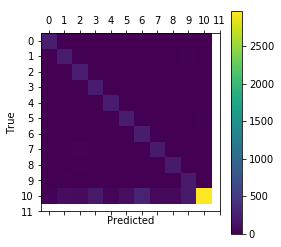

In [67]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [68]:
optimize(num_iterations=4000)

Optimization Iteration:   6001, Training Accuracy:  86.0%
Optimization Iteration:   6101, Training Accuracy:  94.0%
Optimization Iteration:   6201, Training Accuracy:  92.0%
Optimization Iteration:   6301, Training Accuracy:  98.0%
Optimization Iteration:   6401, Training Accuracy:  94.0%
Optimization Iteration:   6501, Training Accuracy:  92.0%
Optimization Iteration:   6601, Training Accuracy:  86.0%
Optimization Iteration:   6701, Training Accuracy:  90.0%
Optimization Iteration:   6801, Training Accuracy:  90.0%
Optimization Iteration:   6901, Training Accuracy:  96.0%
Optimization Iteration:   7001, Training Accuracy:  86.0%
Optimization Iteration:   7101, Training Accuracy:  94.0%
Optimization Iteration:   7201, Training Accuracy:  92.0%
Optimization Iteration:   7301, Training Accuracy:  88.0%
Optimization Iteration:   7401, Training Accuracy:  92.0%
Optimization Iteration:   7501, Training Accuracy:  92.0%
Optimization Iteration:   7601, Training Accuracy:  98.0%
Optimization I

Accuracy on Test-Set: 83.3% (5662 / 6798)
Example errors:
True: right, Pred: left


True: right, Pred: unknown


True: right, Pred: left


True: right, Pred: unknown


True: right, Pred: left


True: right, Pred: unknown


True: right, Pred: left


True: right, Pred: unknown


True: right, Pred: unknown


Confusion Matrix:
[[ 251    4    0    2    2    0    0    0    0    1    1]
 [   0  239    4    3    2    1    0    0    0   13    8]
 [   0    2  241    1    0    2    2    5    2    2    3]
 [   1   12    3  240    0    0    2    1    0    3    2]
 [   3    2    0    0  234    1    0    2    0    2    3]
 [   0    1    1    0    4  239    1    0    0    0   10]
 [   0    1    6    2    1    2  237    4    0    0    4]
 [   0    0   16    0    0    1    4  234    0    1    0]
 [   0    1    9    4    4    0    0    4  221    0    3]
 [   1   31    5    9    2    2    4    4    0  197    5]
 [  34   94   49  124   75  186  139   65   40   86 3329]]


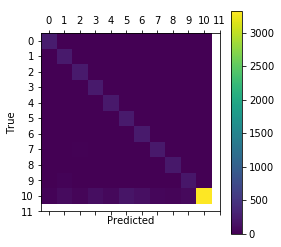

In [69]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

### Creating Tensorboard graphs.

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [43]:
show_graph(tf.get_default_graph().as_graph_def())

In [44]:
session.close()

## Exporting the Model
****
Next we want to export the model to use it in another notebook to predict the test set